In [1]:
import pandas as pd

In [2]:
data=pd.read_csv('Hotels_data_Changed.csv')

In [3]:
#get the top hotels
hotels=data.groupby('Hotel Name')
hotels=hotels.count().sort_values(['Checkin Date'],ascending=False).head(150)
hotelsNames=hotels.index

In [4]:
#get top checkin date
checkinDates=data.loc[data['Hotel Name'].isin(hotelsNames)].groupby(['Checkin Date']).size()
checkinDates=checkinDates.sort_values(ascending=False)
checkinDates=checkinDates.head(40)
checkinDates=checkinDates.index

In [5]:
#take only relevants cols and rows according top hotels and sort by price,drop duplicates
data=data.loc[data['Hotel Name'].isin(hotelsNames)].sort_values('Discount Price')
data=data[['Hotel Name','Checkin Date','Discount Code','Discount Price']]

In [6]:
data=data.drop_duplicates(['Checkin Date','Discount Code','Hotel Name']).sort_values(['Checkin Date','Hotel Name'])

In [7]:
#init clustering list with 150 rows and 161 cols while first col fit to top hotel and other cols init with -1
def initClusteringList(x,y):
        if x==0:
            return hotelsNames[y]
        else:
            return -1
initDate = [[initClusteringList(x,y) for x in range(161)] for y in range(150)]
initDate[0:2]

[['Newark Liberty International Airport Marriott',
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
 

In [8]:
#create list of top date and code(40dates*4codes)=>160 rows
datesAndCode=data.loc[data['Checkin Date'].isin(checkinDates)]
datesAndCode=datesAndCode.drop_duplicates(['Discount Code','Checkin Date'])

In [9]:
#sort Checkin Date,Discount Code
datesAndCode=datesAndCode[['Checkin Date','Discount Code']].sort_values(['Checkin Date','Discount Code'])
len(datesAndCode.values)

160

In [10]:
#update the table according merge with hotel name date and code from the main dataSet
def updateTable(x,y):
    query=datesAndCode.values[y]
    hotel=hotelsNames.values[x]
    line=data.loc[(data['Hotel Name']==hotel)&(data['Checkin Date']==query[0])&(data['Discount Code']==query[1])]
    if not line.empty:
        initDate[x][y+1]= line['Discount Price'].iloc[0]
for y in range(len(datesAndCode)):
    for x in range(hotelsNames.size):
        updateTable(x,y)

In [11]:
len(initDate[0])

161

In [12]:
df = pd.DataFrame(initDate)
df.to_csv("Top_Hotels_prices.csv",index=False,header=False)
#take only prices
normalizeData=df.loc[:,1:]

In [13]:
import numpy as np
#update -1 vals to nan for normalization
def updateNotExistValToNan(x):
    if x==-1:
        return np.nan
    else:
        return x

normalizeDataTransform=normalizeData.applymap(updateNotExistValToNan)
normalizeDataTransform


,1,2,3,4,5,6,7,8,9,10,...,151,152,153,154,155,156,157,158,159,160
0,795.0,872.0,982.0,NaN,NaN,1076.0,846.0,795.0,753.0,836.0,...,871.0,786.0,1245.0,1125.0,NaN,NaN,1235.0,1175.0,NaN,NaN
1,1224.0,1305.0,1335.0,1225.0,1240.0,1183.0,1146.0,1212.0,1020.0,1140.0,...,1099.0,1124.0,1275.0,1155.0,1021.0,972.0,1541.0,1310.0,1186.0,1350.0
2,925.0,955.0,995.0,NaN,NaN,NaN,884.0,925.0,885.0,925.0,...,707.0,651.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1263.0,1277.0,1328.0,NaN,NaN,1285.0,NaN,1261.0,1163.0,1214.0,...,1352.0,1365.0,NaN,1425.0,1388.0,1330.0,NaN,1727.0,1678.0,NaN
4,1715.0,1845.0,1715.0,NaN,1595.0,1595.0,NaN,NaN,1715.0,1675.0,...,2415.0,2555.0,NaN,NaN,2415.0,2855.0,NaN,NaN,2745.0,NaN
5,1495.0,1545.0,1805.0,1625.0,1465.0,NaN,NaN,NaN,1345.0,1390.0,...,1457.0,1605.0,NaN,1655.0,1885.0,NaN,2375.0,2015.0,NaN,NaN
6,3090.0,3255.0,NaN,NaN,NaN,NaN,NaN,NaN,3090.0,3255.0,...,4375.0,4475.0,4375.0,4675.0,4575.0,4645.0,4975.0,5035.0,4815.0,NaN
7,3075.0,2823.0,3126.0,2055.0,1695.0,2823.0,1785.0,NaN,2054.0,2093.0,...,NaN,NaN,2661.0,NaN,NaN,2834.0,NaN,NaN,3342.0,3353.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,777.0,805.0,1015.0,985.0,NaN,NaN,709.0,785.0,845.0,NaN,...,NaN,NaN,928.0,1063.0,1013.0,884.0,1591.0,1495.0,1206.0,1168.0


In [14]:
#normalize data per row according row max and min ignore nan and update nan to -1 as should be
def transformNormal(x):
    maxNum=np.nanmax(x)
    minNum=np.nanmin(x)
    diff=maxNum-minNum
    arr=[]
    for val in x:
        value=-1
        if(~np.isnan(val)):
            value=(((val-minNum)/diff)*100.00)
        arr.append(value)
    return arr
non=normalizeDataTransform.transpose().apply(lambda x:transformNormal(x))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN axis encountered
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN axis encountered
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [15]:
#transform back the data to 150*160 and add hotels names
allData=pd.DataFrame(non.transpose())
allData.fillna(-1,inplace=True)
hotels=pd.DataFrame(hotelsNames)
# hotels.combine_first(allData)
myNormalizedList=hotels.join(allData)
myNormalizedList.to_csv('Normalized_Data_panda.csv')

In [16]:
myNormalizedList

,Hotel Name,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,160
0,Newark Liberty International Airport Marriott,11.594203,22.753623,38.695652,-1.000000,-1.000000,52.318841,18.985507,11.594203,5.507246,...,22.608696,10.289855,76.811594,59.420290,-1.000000,-1.000000,75.362319,66.666667,-1.000000,-1.000000
1,Hilton Garden Inn Times Square,39.341421,46.360485,48.960139,39.428076,40.727903,35.788562,32.582322,38.301560,21.663778,...,28.509532,30.675910,43.760832,33.362218,21.750433,17.504333,66.811092,46.793761,36.048527,50.259965
2,Residence Inn Newark Elizabeth Liberty Interna...,66.666667,73.563218,82.758621,-1.000000,-1.000000,-1.000000,57.241379,66.666667,57.471264,...,16.551724,3.678161,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,Westin New York at Times Square,14.533133,15.587349,19.427711,-1.000000,-1.000000,16.189759,-1.000000,14.382530,7.003012,...,21.234940,22.213855,-1.000000,26.731928,23.945783,19.578313,-1.000000,49.472892,45.783133,-1.000000
4,Loews Regency New York Hotel,5.217391,10.869565,5.217391,-1.000000,0.000000,0.000000,-1.000000,-1.000000,5.217391,...,35.652174,41.739130,-1.000000,-1.000000,35.652174,54.782609,-1.000000,-1.000000,50.000000,-1.000000
5,Viceroy New York,18.000000,21.333333,38.666667,26.666667,16.000000,-1.000000,-1.000000,-1.000000,8.000000,...,15.466667,25.333333,-1.000000,28.666667,44.000000,-1.000000,76.666667,52.666667,-1.000000,-1.000000
6,Four Seasons Hotel New York,1.328502,5.314010,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.328502,...,32.367150,34.782609,32.367150,39.613527,37.198068,38.888889,46.859903,48.309179,42.995169,-1.000000
7,Langham Place New York Fifth Avenue,47.292666,38.656614,49.040439,12.337217,0.000000,38.656614,3.084304,-1.000000,12.302947,...,-1.000000,-1.000000,33.104866,-1.000000,-1.000000,39.033585,-1.000000,-1.000000,56.442769,56.819740
8,The Carlyle A Rosewood Hotel,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
9,DoubleTree by Hilton Metropolitan - New York City,5.287714,7.465008,23.794712,21.461897,-1.000000,-1.000000,0.000000,5.909798,10.575428,...,-1.000000,-1.000000,17.029549,27.527216,23.639191,13.608087,68.584759,61.119751,38.646967,35.692068


In [17]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
print (myNormalizedList.shape)

(150, 161)


In [18]:
X=pd.DataFrame(myNormalizedList.iloc[:,1:])
Z = linkage(X, 'average')

In [19]:
#compares the actual pairwise distances samples to those implied by the hierarchical clustering
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.8833203396457797

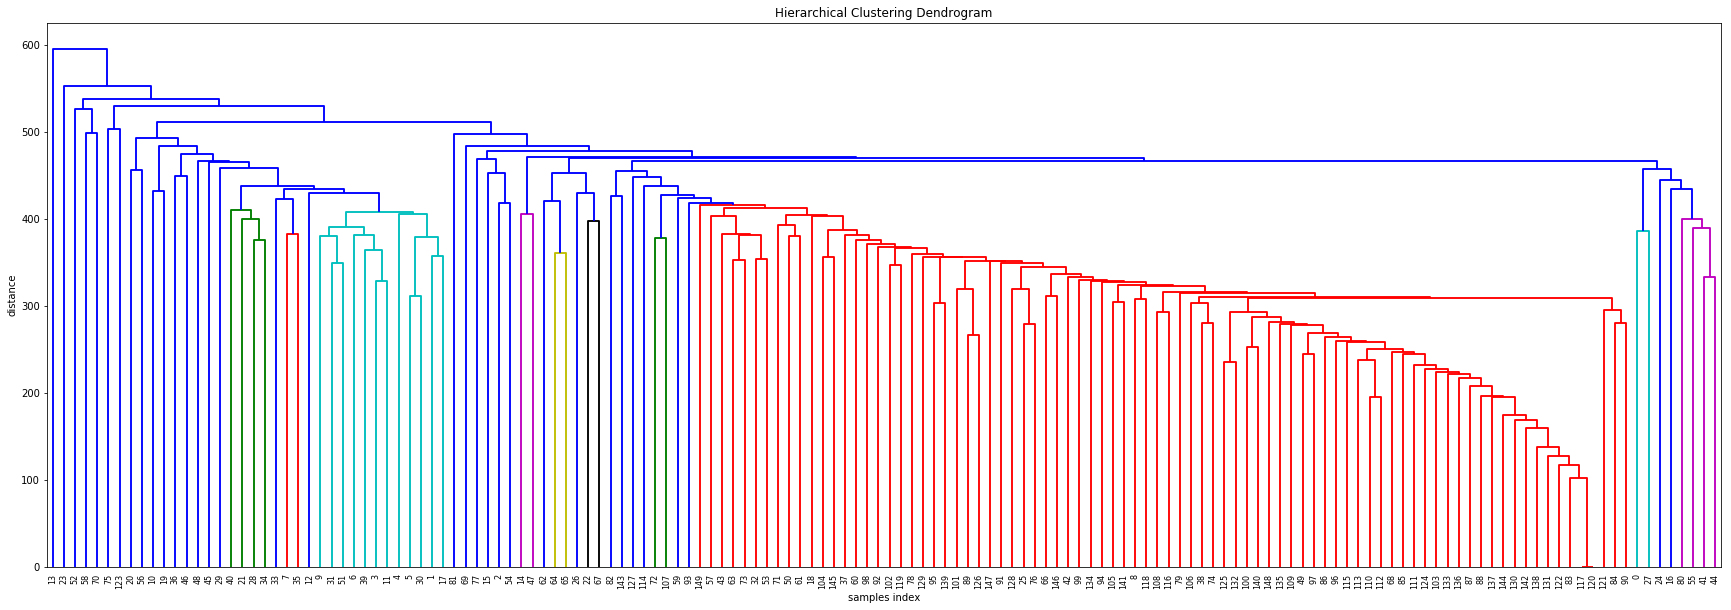

In [20]:
# calculate full dendrogram
plt.figure(figsize=(30, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('samples index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,
    show_contracted=True,
    leaf_font_size=8.
)
dendrogram(
    Z,
    leaf_rotation=90.,
    show_contracted=True,
    leaf_font_size=8.)
plt.show()

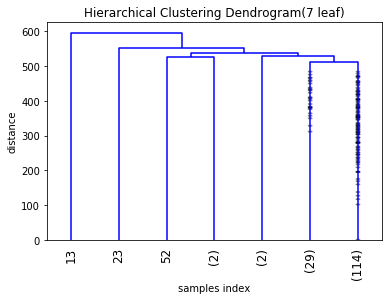

In [21]:
plt.title('Hierarchical Clustering Dendrogram(7 leaf)')
plt.xlabel('samples index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',
    p=7,
    leaf_rotation=90.,
    show_contracted=True,
    leaf_font_size=12.,
)
plt.show()

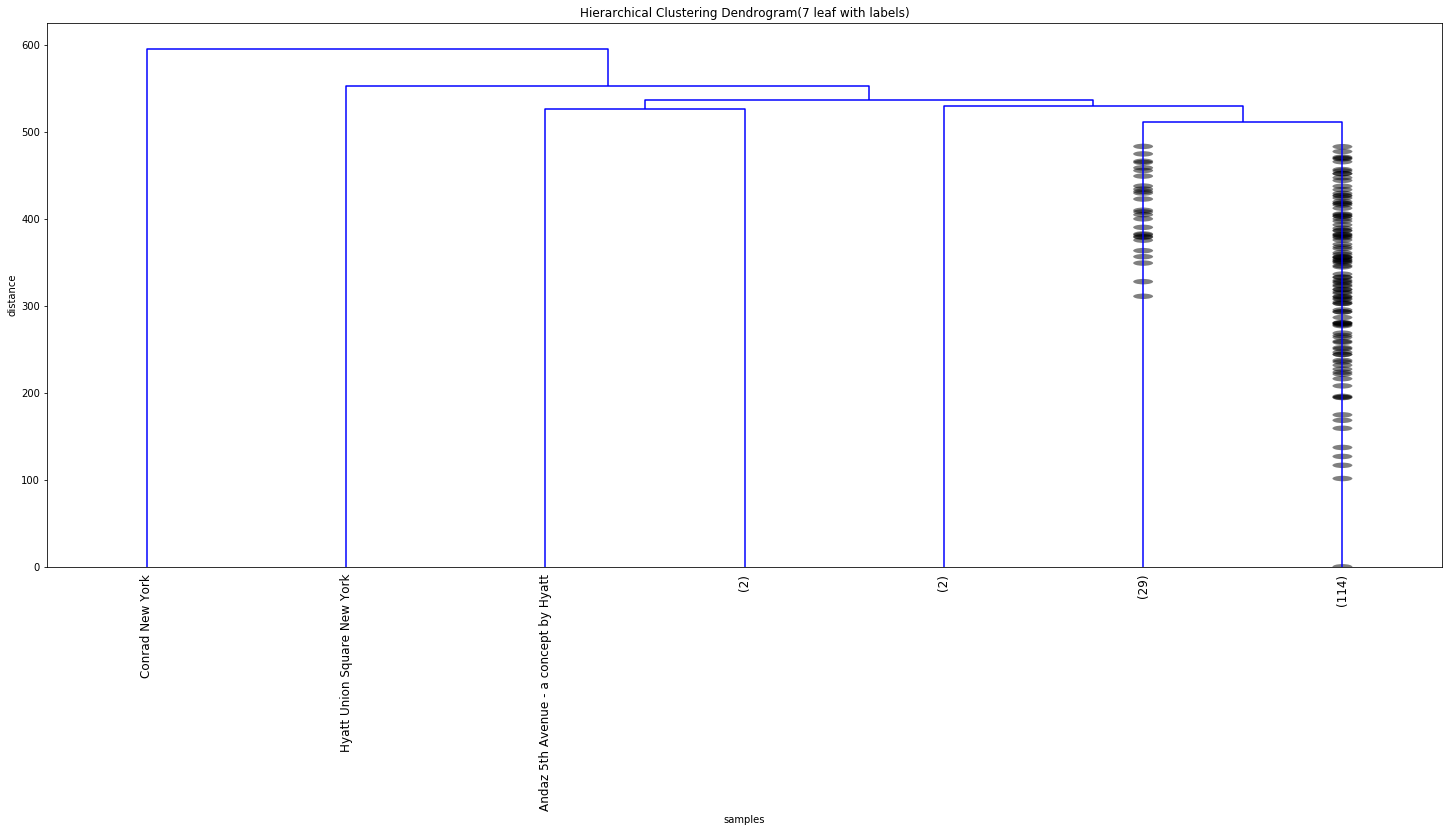

In [22]:

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram(7 leaf with labels)')
plt.xlabel('samples')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',
    p=7,
    labels=hotelsNames,
    leaf_rotation=90.,
    show_contracted=True,
    leaf_font_size=12.,
)
plt.show()

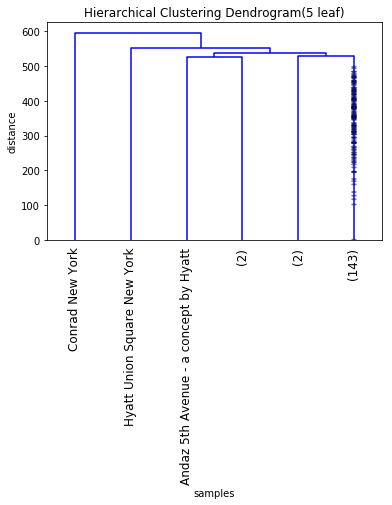

In [23]:
plt.title('Hierarchical Clustering Dendrogram(5 leaf)')
plt.xlabel('samples')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',
    p=6,
    labels=hotelsNames,
    leaf_rotation=90.,
    show_contracted=True,
    leaf_font_size=12.)
plt.show()

In [24]:
#linkage with covariance query (ward)
Z = linkage(X, 'ward')
c, coph_dists = cophenet(Z, pdist(X))
c

0.6313701936406784

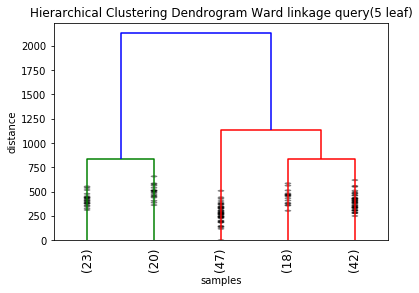

In [25]:
plt.title('Hierarchical Clustering Dendrogram Ward linkage query(5 leaf)')
plt.xlabel('samples')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',
    p=5,
    labels=hotelsNames,
    leaf_rotation=90.,
    show_contracted=True,
    leaf_font_size=12.)
plt.show()